In [1]:
import os
import json
import warnings
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from typing import Literal
from collections import defaultdict
from PIL import Image

In [2]:
from data.dataset_maps import class_mapping
class_mapping

{'names': ['background',
  'double_plant',
  'drydown',
  'endrow',
  'nutrient_deficiency',
  'planter_skip',
  'water',
  'waterway',
  'weed_cluster'],
 'int_labs': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'mask_vals': [0, 50, 75, 100, 125, 150, 175, 200, 255]}

In [3]:
overlay_colors = [
    [1, 0, 0],  # Red
    [0, 1, 0],  # Green
    [0, 0, 1],  # Blue
    [1, 1, 0],  # Yellow
    [1, 0, 1],  # Magenta
    [0, 1, 1],  # Cyan
    [0.5, 0, 0],  # Dark Red
    [0, 0.5, 0],  # Dark Green
    [0, 0, 0.5]   # Dark Blue
]

In [4]:
def find_image_paths(
    dataset: Literal["images_2021", "images_2024"],
    split: Literal["train", "val", "test"],
    image_id: str
):
    if dataset == "images_2021":
        split = "new_" + split
    
    # rgb image
    rgb_image = f"../data/{dataset}/{split}/images/rgb/{image_id}.jpg"
    if not os.path.exists(rgb_image):
        raise FileNotFoundError(f"Image file not found: {rgb_image}")

    # nir image
    nir_image = f"../data/{dataset}/{split}/images/nir/{image_id}.jpg"
    if not os.path.exists(nir_image):
        raise FileNotFoundError(f"Image file not found: {nir_image}")

    # labels
    labels = {}
    for label in [i for i in class_mapping["names"] if i != "background"]:
        label_path = f"../data/{dataset}/{split}/labels/{label}/{image_id}.png"
        if os.path.exists(label_path):
            labels[label] = label_path
        else:
            warnings.warn(f"Image file not found: {label_path}")

    return {"rgb_image": rgb_image, "nir_image": nir_image, "labels": labels}

In [5]:
def read_image(path):
    image = Image.open(path)
    return np.array(image).reshape((*image.size, len(image.getbands())))

def find_images(image_paths):
    d = defaultdict(dict)
    for k, v in image_paths.items():
        if isinstance(v, dict):
            for _k, _v in v.items():
                d[k][_k] = read_image(_v)
        else:
            d[k] = read_image(v)
    return dict(d)

In [6]:
def reformat_labels(labels):
    d = {}
    for i in range(1, 9):
        d[class_mapping["names"][i]] = (labels==i)*255
    return d

In [7]:
def display_image(rgb_image: np.array, nir_image: np.array, labels={}):
    
    images_list = []
    image_names = []
    
    # add RGB image
    images_list.append(rgb_image)
    image_names.append("RGB Image")
    
    # add NIR image
    images_list.append(nir_image)
    image_names.append("NIR Image")

    # overlay setup
    overlay_image = rgb_image.astype(np.float64)
    overlay_labels = np.zeros(rgb_image.shape)
    handles = []

    # reformat labels if labels is np.array with values 0-9
    if isinstance(labels, np.ndarray):
        labels = reformat_labels(labels)
    
    # add labels and overlays
    if len(labels.keys()) > 0:
        for label, image in labels.items():
    
            # calculate label percentage
            label_percentage = np.sum(image != 0) / image.size * 100
            label_percentage_string = f"{label} ({label_percentage:.2f}%)"
    
            # add label image
            images_list.append(image)
            image_names.append("Label: %s" % label_percentage_string)
    
            # add overlay for the label if present in image
            if label_percentage > 0:
                overlay_color = overlay_colors[class_mapping["names"].index(label)]
                overlay_labels += 0.5 * image * overlay_color
                handles.append(plt.Line2D([], [], color=overlay_color, label=label_percentage_string))

        # add overlay image if at least one label is present
        if len(handles) > 0:
            overlay_image = rgb_image.astype(np.float64) + overlay_labels
            overlay_image = np.clip(overlay_image.astype(int), 0, 255)
            images_list.insert(0, overlay_image)
            image_names.insert(0, "Overlay Image")
    
    # calculate how many rows and cols figure should have
    n = len(images_list)
    ncols = 5
    nrows = max((n-1) // ncols + 1, 2)
    plt.figure(figsize=(25, nrows*5))

    # iterate through list of images and plot
    for i in range(n):

        # choose plot
        plt.subplot(nrows, ncols, i+1)

        # use cmap="gray" if it is image has 1 image
        if images_list[i].shape[2] == 3:
            plt.imshow(images_list[i])
        elif images_list[i].shape[2] == 1:
            plt.imshow(images_list[i][:,:,0], cmap="gray")

        # set title
        plt.title(image_names[i])

        # add legend to overlay image
        if i == 0 and len(handles) > 0:
            plt.legend(handles=handles, loc="upper left")

        # axis off for all images
        plt.axis("off")

{
    "rgb_image": "../data/images_2021/new_val/images/rgb/1AD76MIZN_659-8394-1171-8906.jpg",
    "nir_image": "../data/images_2021/new_val/images/nir/1AD76MIZN_659-8394-1171-8906.jpg",
    "labels": {
        "double_plant": "../data/images_2021/new_val/labels/double_plant/1AD76MIZN_659-8394-1171-8906.png",
        "drydown": "../data/images_2021/new_val/labels/drydown/1AD76MIZN_659-8394-1171-8906.png",
        "endrow": "../data/images_2021/new_val/labels/endrow/1AD76MIZN_659-8394-1171-8906.png",
        "nutrient_deficiency": "../data/images_2021/new_val/labels/nutrient_deficiency/1AD76MIZN_659-8394-1171-8906.png",
        "planter_skip": "../data/images_2021/new_val/labels/planter_skip/1AD76MIZN_659-8394-1171-8906.png",
        "water": "../data/images_2021/new_val/labels/water/1AD76MIZN_659-8394-1171-8906.png",
        "waterway": "../data/images_2021/new_val/labels/waterway/1AD76MIZN_659-8394-1171-8906.png",
        "weed_cluster": "../data/images_2021/new_val/labels/weed_cluster

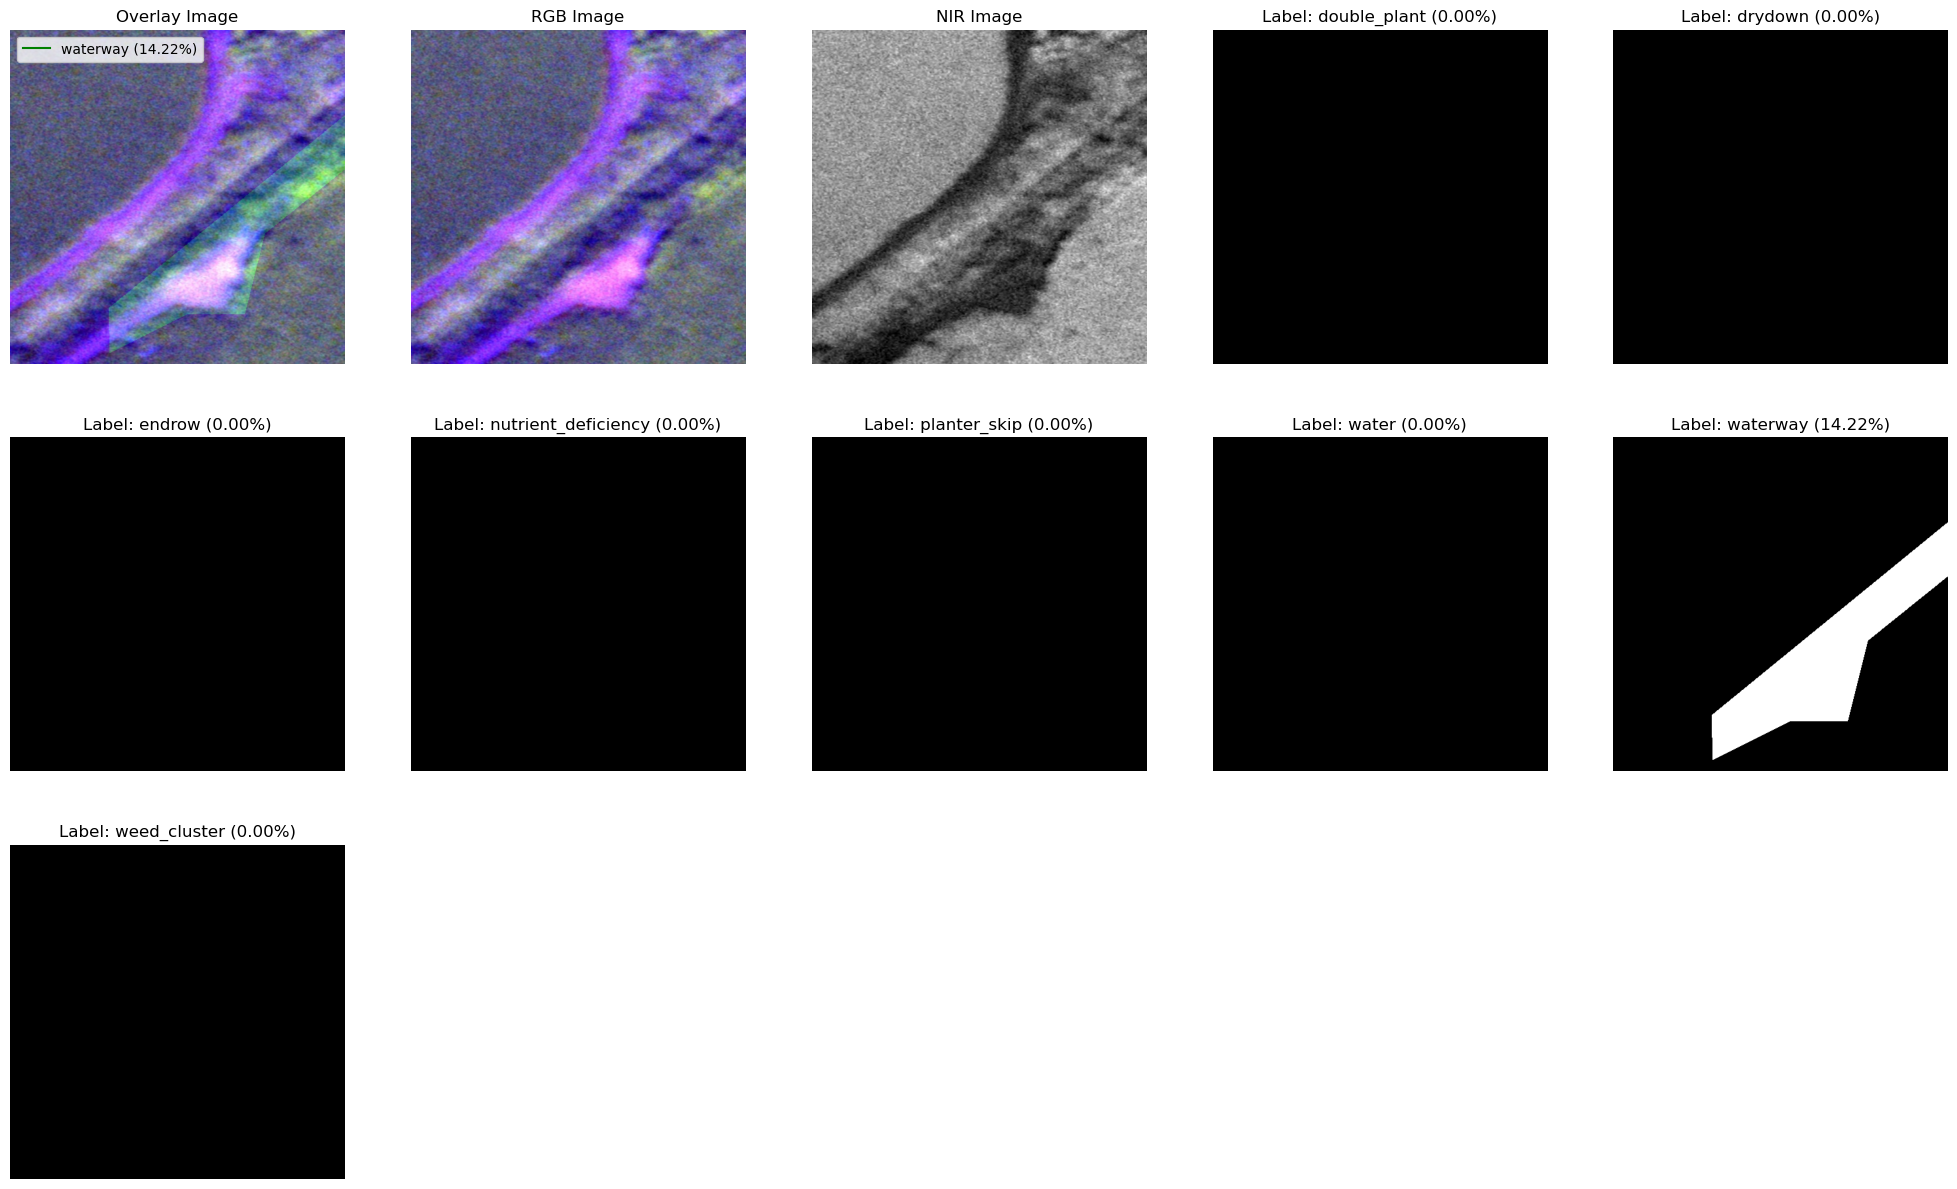

In [8]:
image_paths = find_image_paths("images_2021", "val", "1AD76MIZN_659-8394-1171-8906")
print(json.dumps(image_paths, indent=4))
images = find_images(image_paths)
display_image(images["rgb_image"], images["nir_image"], images["labels"])

C:\Users\Francis\AppData\Local\Temp\ipykernel_18500\3071456109.py:26: UserWarning: Image file not found: ../data/images_2024/train/labels/double_plant/1AR7NG3KG_row0_col0.png
  warnings.warn(f"Image file not found: {label_path}")
C:\Users\Francis\AppData\Local\Temp\ipykernel_18500\3071456109.py:26: UserWarning: Image file not found: ../data/images_2024/train/labels/drydown/1AR7NG3KG_row0_col0.png
  warnings.warn(f"Image file not found: {label_path}")
C:\Users\Francis\AppData\Local\Temp\ipykernel_18500\3071456109.py:26: UserWarning: Image file not found: ../data/images_2024/train/labels/endrow/1AR7NG3KG_row0_col0.png
  warnings.warn(f"Image file not found: {label_path}")
C:\Users\Francis\AppData\Local\Temp\ipykernel_18500\3071456109.py:26: UserWarning: Image file not found: ../data/images_2024/train/labels/nutrient_deficiency/1AR7NG3KG_row0_col0.png
  warnings.warn(f"Image file not found: {label_path}")
C:\Users\Francis\AppData\Local\Temp\ipykernel_18500\3071456109.py:26: UserWarning: I

{
    "rgb_image": "../data/images_2024/train/images/rgb/1AR7NG3KG_row0_col0.jpg",
    "nir_image": "../data/images_2024/train/images/nir/1AR7NG3KG_row0_col0.jpg",
    "labels": {}
}


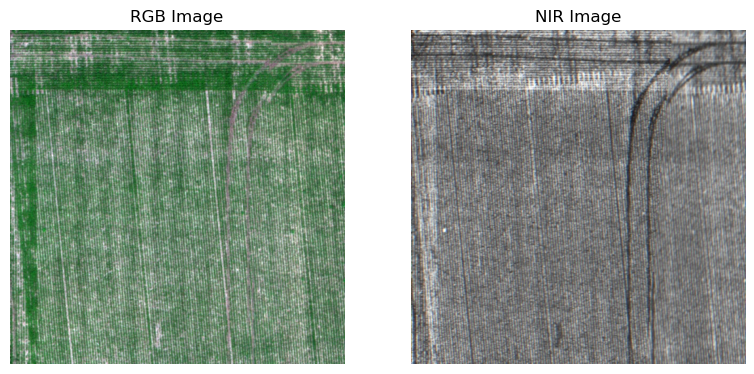

In [9]:
image_paths = find_image_paths("images_2024", "train", "1AR7NG3KG_row0_col0")        
print(json.dumps(image_paths, indent=4))
images = find_images(image_paths)
display_image(images["rgb_image"], images["nir_image"])